# Preprocessing for clinical data
Largely adapted from the [Multisurv model clinical preprocessing](https://github.com/luisvalesilva/multisurv/blob/master/data/preprocess_clinical.ipynb)

In [1]:
import pandas as pd 
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier

In [3]:
gene_expression_data = 'data/data_mrna_illumina_microarray.txt'
cna_data = 'data/data_cna.txt'
clinical_data = 'data/data_clinical_patient.txt'

In [5]:
results_dir = Path('./results')
results_dir.mkdir(parents=True, exist_ok=True)

### 1.1. Exploring data

In [6]:
gene_exp_df = pd.read_table(gene_expression_data, sep='\t')
gene_exp_df.shape

(20603, 1982)

In [7]:
gene_exp_df.head()

,Hugo_Symbol,Entrez_Gene_Id,MB-0362,MB-0346,MB-0386,MB-0574,MB-0185,MB-0503,MB-0641,MB-0201,...,MB-6192,MB-4820,MB-5527,MB-5167,MB-5465,MB-5453,MB-5471,MB-5127,MB-4313,MB-4823
0,RERE,473,8.676978,9.653589,9.033589,8.814855,8.736406,9.274265,9.286585,8.437347,...,8.804947,9.991215,9.595923,9.637249,8.131637,9.606915,9.049296,8.858622,8.415867,9.902776
1,RNF165,494470,6.075331,6.687887,5.910885,5.628740,6.392422,5.908698,6.206729,6.095592,...,5.601472,7.103160,6.418987,6.203370,9.101942,7.427494,6.850000,6.550450,6.831722,7.338318
2,PHF7,51533,5.838270,5.600876,6.030718,5.849428,5.542133,5.964661,5.783374,5.737572,...,5.922894,6.181493,5.992153,6.230316,5.644587,5.927409,6.117095,5.936371,7.408960,5.875759
3,CIDEA,1149,6.397503,5.246319,10.111816,6.116868,5.184098,7.828171,8.744149,5.480091,...,6.488136,5.612846,6.241160,5.560488,5.611189,5.927031,6.374305,5.963092,9.181768,5.596873
4,TENT2,167153,7.906217,8.267256,7.959291,9.206376,8.162845,8.706646,8.518929,7.478413,...,8.534527,8.203819,8.813103,8.612911,7.798269,8.520545,8.499637,9.320207,6.804085,8.436732


In [8]:
cna_df = pd.read_table(cna_data, sep='\t')
cna_df.shape

(22544, 2175)

In [9]:
clinical_df = pd.read_table(clinical_data, sep='\t')
clinical_df.shape

(2513, 24)

In [10]:
clinical_df.head()

,#Patient Identifier,Lymph nodes examined positive,Nottingham prognostic index,Cellularity,Chemotherapy,Cohort,ER status measured by IHC,HER2 status measured by SNP6,Hormone Therapy,Inferred Menopausal State,...,Overall Survival Status,Pam50 + Claudin-low subtype,3-Gene classifier subtype,Patient's Vital Status,Primary Tumor Laterality,Radio Therapy,Tumor Other Histologic Subtype,Type of Breast Surgery,Relapse Free Status,Relapse Free Status (Months)
0,#Identifier to uniquely specify a patient.,Number of lymphnodes positive,Nottingham prognostic index,Tumor Content,Chemotherapy.,Cohort.,ER status measured by IHC,HER2 status measured by SNP6,Hormone Therapy,Inferred Menopausal State,...,Overall patient survival status.,Pam50 + Claudin-low subtype,3-Gene classifier subtype,The survival state of the person.,"For tumors in paired organs, designates the si...",Radio Therapy,Text to describe a tumor's histologic subtype ...,Type of Breast Surgery,Relapse Free Status (Recurred = cases where th...,Time until last follow-up or relapse (in months)
1,#STRING,STRING,NUMBER,STRING,STRING,STRING,STRING,STRING,STRING,STRING,...,STRING,STRING,STRING,STRING,STRING,STRING,STRING,STRING,STRING,NUMBER
2,#1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
3,PATIENT_ID,LYMPH_NODES_EXAMINED_POSITIVE,NPI,CELLULARITY,CHEMOTHERAPY,COHORT,ER_IHC,HER2_SNP6,HORMONE_THERAPY,INFERRED_MENOPAUSAL_STATE,...,OS_STATUS,CLAUDIN_SUBTYPE,THREEGENE,VITAL_STATUS,LATERALITY,RADIO_THERAPY,HISTOLOGICAL_SUBTYPE,BREAST_SURGERY,RFS_STATUS,RFS_MONTHS
4,MB-0000,10,6.044,NaN,NO,1,Positve,NEUTRAL,YES,Post,...,0:LIVING,claudin-low,ER-/HER2-,Living,Right,YES,Ductal/NST,MASTECTOMY,0:Not Recurred,138.65


### 1.1. Dropping unnecessary rows and columns from clinical data

In [11]:
# Dropping unnecessary rows and columns
clinical_df = clinical_df.drop(clinical_df.index[:4]).reset_index() #headers
clinical_df = clinical_df.drop(clinical_df.columns[0],axis=1) #index column
clinical_df.head()

,#Patient Identifier,Lymph nodes examined positive,Nottingham prognostic index,Cellularity,Chemotherapy,Cohort,ER status measured by IHC,HER2 status measured by SNP6,Hormone Therapy,Inferred Menopausal State,...,Overall Survival Status,Pam50 + Claudin-low subtype,3-Gene classifier subtype,Patient's Vital Status,Primary Tumor Laterality,Radio Therapy,Tumor Other Histologic Subtype,Type of Breast Surgery,Relapse Free Status,Relapse Free Status (Months)
0,MB-0000,10,6.044,NaN,NO,1,Positve,NEUTRAL,YES,Post,...,0:LIVING,claudin-low,ER-/HER2-,Living,Right,YES,Ductal/NST,MASTECTOMY,0:Not Recurred,138.65
1,MB-0002,0,4.02,High,NO,1,Positve,NEUTRAL,YES,Pre,...,0:LIVING,LumA,ER+/HER2- High Prolif,Living,Right,YES,Ductal/NST,BREAST CONSERVING,0:Not Recurred,83.52
2,MB-0005,1,4.03,High,YES,1,Positve,NEUTRAL,YES,Pre,...,1:DECEASED,LumB,NaN,Died of Disease,Right,NO,Ductal/NST,MASTECTOMY,1:Recurred,151.28
3,MB-0006,3,4.05,Moderate,YES,1,Positve,NEUTRAL,YES,Pre,...,0:LIVING,LumB,NaN,Living,Right,YES,Mixed,MASTECTOMY,0:Not Recurred,162.76
4,MB-0008,8,6.08,High,YES,1,Positve,NEUTRAL,YES,Post,...,1:DECEASED,LumB,ER+/HER2- High Prolif,Died of Disease,Right,YES,Mixed,MASTECTOMY,1:Recurred,18.55


### 1.2 Selecting patients that have all 3 data types: gene expression, CNA, clinical

In [12]:
gene_exp_patients = set(gene_exp_df.columns[2:])
cna_patients = set(cna_df.columns[2:])
clinical_patients = set(clinical_df['#Patient Identifier'])

common_patients = gene_exp_patients.intersection(cna_patients, clinical_patients)

gene_exp_columns_to_drop = [col for col in gene_exp_df.columns[2:] if col not in common_patients]
gene_exp_df = gene_exp_df.drop(columns=gene_exp_columns_to_drop)
gene_exp_df.to_csv(results_dir/'gene_expression.csv')

cna_columns_to_drop = [col for col in cna_df.columns[2:] if col not in common_patients]
cna_df = cna_df.drop(columns=cna_columns_to_drop)
cna_df.to_csv(results_dir/'cna.csv')

clinical_df = clinical_df[clinical_df['#Patient Identifier'].isin(common_patients)]

In [13]:
gene_exp_df.shape

(20603, 1982)

In [14]:
cna_df.shape

(22544, 1982)

In [15]:
clinical_df.shape

(1980, 24)

### 1.3 Checking for missing clinical data

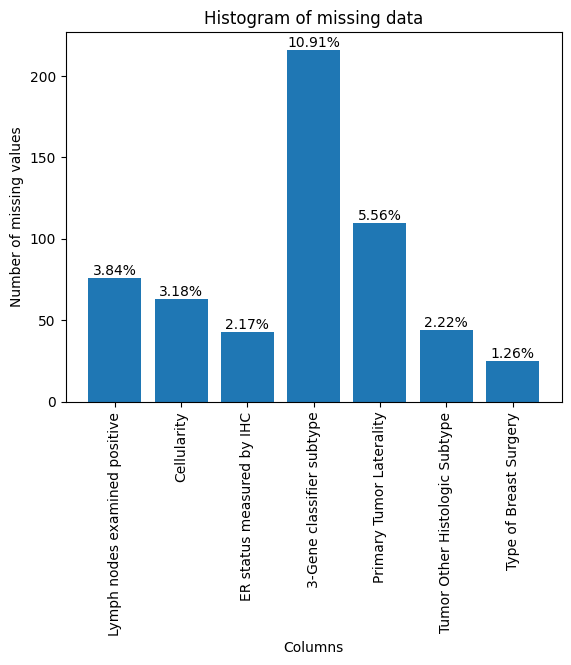

In [16]:
n = clinical_df.shape[0]

missing_counts = {}  # Dictionary to store missing value counts for each column

for col in clinical_df.columns:
    if col == '#Patient Identifier':
        continue

    n_missing = clinical_df[col].isnull().sum()
    if n_missing>1:  
        missing_counts[col] = n_missing

plt.bar(missing_counts.keys(), missing_counts.values())
plt.xlabel('Columns')
plt.ylabel('Number of missing values')
plt.title('Histogram of missing data')
for i, (col, count) in enumerate(missing_counts.items()):
    percentage = count / n * 100
    plt.text(i, count, f'{percentage:.2f}%', ha='center', va='bottom')
plt.xticks(rotation=90)  
plt.savefig(results_dir/'missing_data_hist.png',dpi=300)
plt.show()

In [17]:
# Making sure all patients are female
clinical_df['Sex'].value_counts()

Sex
Female    1980
Name: count, dtype: int64

### 1.4. Selecting clinical features
For now selecting most of the features, but can fine tune later based on cancer subtypes

In [18]:
clinical_df.columns

Index(['#Patient Identifier', 'Lymph nodes examined positive',
       'Nottingham prognostic index', 'Cellularity', 'Chemotherapy', 'Cohort',
       'ER status measured by IHC', 'HER2 status measured by SNP6',
       'Hormone Therapy', 'Inferred Menopausal State', 'Sex',
       'Integrative Cluster', 'Age at Diagnosis', 'Overall Survival (Months)',
       'Overall Survival Status', 'Pam50 + Claudin-low subtype',
       '3-Gene classifier subtype', 'Patient's Vital Status',
       'Primary Tumor Laterality', 'Radio Therapy',
       'Tumor Other Histologic Subtype', 'Type of Breast Surgery',
       'Relapse Free Status', 'Relapse Free Status (Months)'],
      dtype='object')

In [19]:
# Selecting initial variables
# Excluding 'Relapse Free Status', 'Relapse Free Status (Months)' as they directly indicate whether the patient is L or D
label_cols = ['#Patient Identifier', 'Overall Survival (Months)']
keep_cols = ['Lymph nodes examined positive', 'Nottingham prognostic index', 'Cellularity', 'Chemotherapy','ER status measured by IHC',
            'HER2 status measured by SNP6', 'Hormone Therapy', 'Inferred Menopausal State', 'Integrative Cluster', 'Age at Diagnosis', 
             'Pam50 + Claudin-low subtype', '3-Gene classifier subtype', 'Primary Tumor Laterality', 'Tumor Other Histologic Subtype',  
             'Radio Therapy','Type of Breast Surgery']
columns_to_drop = [col for col in clinical_df.columns if col not in label_cols + keep_cols]
clinical_df = clinical_df.drop(columns=columns_to_drop)
clinical_df.shape

(1980, 18)

In [20]:
clinical_df.head()

,#Patient Identifier,Lymph nodes examined positive,Nottingham prognostic index,Cellularity,Chemotherapy,ER status measured by IHC,HER2 status measured by SNP6,Hormone Therapy,Inferred Menopausal State,Integrative Cluster,Age at Diagnosis,Overall Survival (Months),Pam50 + Claudin-low subtype,3-Gene classifier subtype,Primary Tumor Laterality,Radio Therapy,Tumor Other Histologic Subtype,Type of Breast Surgery
0,MB-0000,10,6.044,NaN,NO,Positve,NEUTRAL,YES,Post,4ER+,75.65,140.5,claudin-low,ER-/HER2-,Right,YES,Ductal/NST,MASTECTOMY
1,MB-0002,0,4.02,High,NO,Positve,NEUTRAL,YES,Pre,4ER+,43.19,84.63333333,LumA,ER+/HER2- High Prolif,Right,YES,Ductal/NST,BREAST CONSERVING
2,MB-0005,1,4.03,High,YES,Positve,NEUTRAL,YES,Pre,3,48.87,163.7,LumB,NaN,Right,NO,Ductal/NST,MASTECTOMY
3,MB-0006,3,4.05,Moderate,YES,Positve,NEUTRAL,YES,Pre,9,47.68,164.9333333,LumB,NaN,Right,YES,Mixed,MASTECTOMY
4,MB-0008,8,6.08,High,YES,Positve,NEUTRAL,YES,Post,9,76.97,41.36666667,LumB,ER+/HER2- High Prolif,Right,YES,Mixed,MASTECTOMY


### 1.5 Labeling data
L - 0, D - 1

In [21]:
clinical_df['event'] = clinical_df['Overall Survival (Months)'].astype(float).apply(lambda x: 0 if x > 60 else 1)
clinical_L_df = clinical_df.loc[clinical_df['Overall Survival (Months)']==0]
clinical_D_df = clinical_df.loc[clinical_df['Overall Survival (Months)']==1]
clinical_df['event'].value_counts()

event
0    1489
1     491
Name: count, dtype: int64

In [22]:
# Because the counts in event categories are substantially different, need decrease the number of L samples
n = 500
clinical_D_df = clinical_df.loc[clinical_df['event'] == 1]
clinical_L_df = pd.DataFrame(clinical_df.loc[clinical_df['event'] == 0].sample(n))
clinical_df = pd.concat([clinical_L_df,clinical_D_df]).reset_index(drop=True)
clinical_df['event'].value_counts()

event
0    500
1    491
Name: count, dtype: int64

In [23]:
clinical_df.set_index('#Patient Identifier', inplace=True)
clinical_df.head()

,Lymph nodes examined positive,Nottingham prognostic index,Cellularity,Chemotherapy,ER status measured by IHC,HER2 status measured by SNP6,Hormone Therapy,Inferred Menopausal State,Integrative Cluster,Age at Diagnosis,Overall Survival (Months),Pam50 + Claudin-low subtype,3-Gene classifier subtype,Primary Tumor Laterality,Radio Therapy,Tumor Other Histologic Subtype,Type of Breast Surgery,event
#Patient Identifier,,,,,,,,,,,,,,,,,,
MB-5601,3,4.032,High,NO,Positve,NEUTRAL,YES,Post,3,61.73,214.8,LumA,ER+/HER2- Low Prolif,Left,YES,Ductal/NST,BREAST CONSERVING,0
MB-2669,0,3.048,Moderate,NO,Positve,NEUTRAL,YES,Post,6,62.56,73.7,LumA,ER+/HER2- Low Prolif,Left,NO,Ductal/NST,MASTECTOMY,0
MB-2618,0,3.032,High,NO,Positve,GAIN,NO,Post,1,66.22,89.1,LumB,NaN,Right,YES,Ductal/NST,BREAST CONSERVING,0
MB-5230,0,3.03,Moderate,NO,Positve,NEUTRAL,NO,Pre,3,48.17,176.5,LumA,ER+/HER2- Low Prolif,Right,YES,Mucinous,BREAST CONSERVING,0
MB-0266,0,1.06,Moderate,NO,NaN,GAIN,YES,Post,8,84.88,90.66666667,LumA,NaN,Left,YES,Mixed,MASTECTOMY,0


### 1.6 Test-val-test splits

In [24]:
train_val_data, test_data = train_test_split(clinical_df, test_size=0.15, stratify=clinical_df['event'], random_state=42)
train_data, val_data = train_test_split(train_val_data, test_size=0.125, stratify=train_val_data['event'], random_state=42)

In [25]:
train_data.shape

(736, 18)

In [26]:
val_data.shape

(106, 18)

In [27]:
test_data.shape

(149, 18)

In [28]:
def get_split_group(id_code):
    if id_code in list(train_data.index):
        return 'train'
    elif id_code in val_data.index:
        return 'val'
    elif id_code in test_data.index:
        return 'test'
    else:
        print('Found NaN!')

In [29]:
clinical_df['group'] = 'Missing'
clinical_df['group'] = [get_split_group(x) for x in list(clinical_df.index)]

In [30]:
clinical_df.head()

,Lymph nodes examined positive,Nottingham prognostic index,Cellularity,Chemotherapy,ER status measured by IHC,HER2 status measured by SNP6,Hormone Therapy,Inferred Menopausal State,Integrative Cluster,Age at Diagnosis,Overall Survival (Months),Pam50 + Claudin-low subtype,3-Gene classifier subtype,Primary Tumor Laterality,Radio Therapy,Tumor Other Histologic Subtype,Type of Breast Surgery,event,group
#Patient Identifier,,,,,,,,,,,,,,,,,,,
MB-5601,3,4.032,High,NO,Positve,NEUTRAL,YES,Post,3,61.73,214.8,LumA,ER+/HER2- Low Prolif,Left,YES,Ductal/NST,BREAST CONSERVING,0,train
MB-2669,0,3.048,Moderate,NO,Positve,NEUTRAL,YES,Post,6,62.56,73.7,LumA,ER+/HER2- Low Prolif,Left,NO,Ductal/NST,MASTECTOMY,0,train
MB-2618,0,3.032,High,NO,Positve,GAIN,NO,Post,1,66.22,89.1,LumB,NaN,Right,YES,Ductal/NST,BREAST CONSERVING,0,train
MB-5230,0,3.03,Moderate,NO,Positve,NEUTRAL,NO,Pre,3,48.17,176.5,LumA,ER+/HER2- Low Prolif,Right,YES,Mucinous,BREAST CONSERVING,0,val
MB-0266,0,1.06,Moderate,NO,NaN,GAIN,YES,Post,8,84.88,90.66666667,LumA,NaN,Left,YES,Mixed,MASTECTOMY,0,train


### 1.7 Input missing numeric data with median value and encode categorical variables

In [31]:
print('~~ MISSING DATA ~~')
print()
skip = ['project_id', 'days_to_death', 'days_to_last_follow_up']

n = clinical_df.shape[0]

for v in clinical_df.columns:
    if v not in skip:
        n_missing = sum(clinical_df[v].isnull())
        if n_missing > 0:
            print(f'{v}: {n_missing} ({round(n_missing / n * 100, 2)}%)')

~~ MISSING DATA ~~

Lymph nodes examined positive: 37 (3.73%)
Cellularity: 22 (2.22%)
ER status measured by IHC: 18 (1.82%)
3-Gene classifier subtype: 117 (11.81%)
Primary Tumor Laterality: 72 (7.27%)
Tumor Other Histologic Subtype: 15 (1.51%)
Type of Breast Surgery: 17 (1.72%)


In [32]:
def input_missing_values(feature, df):
    train_subset = df.loc[df['group'] == 'train', feature]
    try:
        input_value = train_subset.median()
        print(f'Median "{feature}": {input_value}')
    except TypeError:
        input_value = train_subset.mode().iloc[0]
        print(f'Mode "{feature}": {input_value}')

    df[feature].fillna(input_value, inplace=True)
    
    return df

In [33]:
clinical_df = input_missing_values(feature='Lymph nodes examined positive', df=clinical_df)

Median "Lymph nodes examined positive": 1.0


In [34]:
print('~~ MISSING DATA ~~')
print()

n = clinical_df.shape[0]

for v in clinical_df.columns:
    n_missing = sum(clinical_df[v].isnull())
    if n_missing > 0:
        print(f'{v}: {n_missing} ({round(n_missing / n * 100, 2)}%)')

~~ MISSING DATA ~~

Cellularity: 22 (2.22%)
ER status measured by IHC: 18 (1.82%)
3-Gene classifier subtype: 117 (11.81%)
Primary Tumor Laterality: 72 (7.27%)
Tumor Other Histologic Subtype: 15 (1.51%)
Type of Breast Surgery: 17 (1.72%)


In [35]:
# Save the df for plotting later
clinical_plot = clinical_df.copy()

### Scale continous features

In [36]:
id_groups = {
    'train': list(clinical_df.loc[clinical_df['group'] == 'train', ].index),
    'val': list(clinical_df.loc[clinical_df['group'] == 'val', ].index),
    'test': list(clinical_df.loc[clinical_df['group'] == 'test', ].index)}

In [37]:
continuous = ['Age at Diagnosis', 'Nottingham prognostic index']

In [38]:
def min_max_scale(data, features, groups):
    train = data.loc[data.index.isin(groups['train']), features]

    scaler = MinMaxScaler()
    columns = train.columns
    scaler = scaler.fit(train[columns])
    
    data.loc[data.index.isin(groups['train']), features] = scaler.transform(
        train)
    data.loc[data.index.isin(groups['val']), features] = scaler.transform(
        data.loc[data.index.isin(groups['val']), features])
    data.loc[data.index.isin(groups['test']), features] = scaler.transform(
        data.loc[data.index.isin(groups['test']), features])
    
    return data

In [39]:
clinical_df = min_max_scale(data=clinical_df, features=continuous, groups = id_groups)
clinical_df.head()

,Lymph nodes examined positive,Nottingham prognostic index,Cellularity,Chemotherapy,ER status measured by IHC,HER2 status measured by SNP6,Hormone Therapy,Inferred Menopausal State,Integrative Cluster,Age at Diagnosis,Overall Survival (Months),Pam50 + Claudin-low subtype,3-Gene classifier subtype,Primary Tumor Laterality,Radio Therapy,Tumor Other Histologic Subtype,Type of Breast Surgery,event,group
#Patient Identifier,,,,,,,,,,,,,,,,,,,
MB-5601,3,0.565672,High,NO,Positve,NEUTRAL,YES,Post,3,0.535234,214.8,LumA,ER+/HER2- Low Prolif,Left,YES,Ductal/NST,BREAST CONSERVING,0,train
MB-2669,0,0.38209,Moderate,NO,Positve,NEUTRAL,YES,Post,6,0.546396,73.7,LumA,ER+/HER2- Low Prolif,Left,NO,Ductal/NST,MASTECTOMY,0,train
MB-2618,0,0.379104,High,NO,Positve,GAIN,NO,Post,1,0.595616,89.1,LumB,NaN,Right,YES,Ductal/NST,BREAST CONSERVING,0,train
MB-5230,0,0.378731,Moderate,NO,Positve,NEUTRAL,NO,Pre,3,0.352878,176.5,LumA,ER+/HER2- Low Prolif,Right,YES,Mucinous,BREAST CONSERVING,0,val
MB-0266,0,0.011194,Moderate,NO,NaN,GAIN,YES,Post,8,0.846557,90.66666667,LumA,NaN,Left,YES,Mixed,MASTECTOMY,0,train


### Encode categorical variables

In [40]:
clinical_df = clinical_df.drop(columns=['Overall Survival (Months)'])

In [41]:
clinical_df.columns

Index(['Lymph nodes examined positive', 'Nottingham prognostic index',
       'Cellularity', 'Chemotherapy', 'ER status measured by IHC',
       'HER2 status measured by SNP6', 'Hormone Therapy',
       'Inferred Menopausal State', 'Integrative Cluster', 'Age at Diagnosis',
       'Pam50 + Claudin-low subtype', '3-Gene classifier subtype',
       'Primary Tumor Laterality', 'Radio Therapy',
       'Tumor Other Histologic Subtype', 'Type of Breast Surgery', 'event',
       'group'],
      dtype='object')

In [42]:
skip = ['event', 'group', 'Lymph nodes examined positive']

In [43]:
categorical = [col for col in clinical_df.columns if col not in skip + continuous]

In [48]:
split_groups = ['train', 'val', 'test']

label_encoders = {}
for feature in categorical:
    clinical_df[feature] = clinical_df[feature].astype(str)
    label_encoders[feature] = LabelEncoder()
    label_encoders[feature].fit(
        clinical_df.loc[clinical_df['group'] == 'train', feature])

for group in split_groups:
    for feature in categorical:
        clinical_df.loc[
            clinical_df['group'] == group, feature] = label_encoders[feature].transform(
            clinical_df.loc[clinical_df['group'] == group, feature])

Cellularity
Chemotherapy
ER status measured by IHC
HER2 status measured by SNP6
Hormone Therapy
Inferred Menopausal State
Integrative Cluster
Pam50 + Claudin-low subtype
3-Gene classifier subtype
Primary Tumor Laterality
Radio Therapy
Tumor Other Histologic Subtype
Type of Breast Surgery


ValueError: y contains previously unseen labels: 'GAIN'

In [85]:
clinical_df.head()

,Lymph nodes examined positive,Nottingham prognostic index,Cellularity,Chemotherapy,ER status measured by IHC,HER2 status measured by SNP6,Hormone Therapy,Inferred Menopausal State,Integrative Cluster,Age at Diagnosis,Pam50 + Claudin-low subtype,3-Gene classifier subtype,Primary Tumor Laterality,Radio Therapy,Tumor Other Histologic Subtype,Type of Breast Surgery,event,group
#Patient Identifier,,,,,,,,,,,,,,,,,,
MB-4928,1,0.76015,2,0,1,0,1,0,6,0.71638,1,4,1,0,0,1,0,train
MB-4876,0,0.386466,1,0,1,2,0,1,4,0.275955,6,2,0,1,1,0,0,train
MB-5332,1,0.570677,0,0,1,0,1,0,6,0.63206,1,0,0,0,0,1,0,train
MB-4744,2,0.757895,0,0,1,2,1,0,9,0.568585,3,4,1,1,0,0,0,val
MB-5531,0,0.381579,0,0,0,2,0,0,1,0.600188,6,2,1,1,0,0,0,train


### 1.8 Select top important features

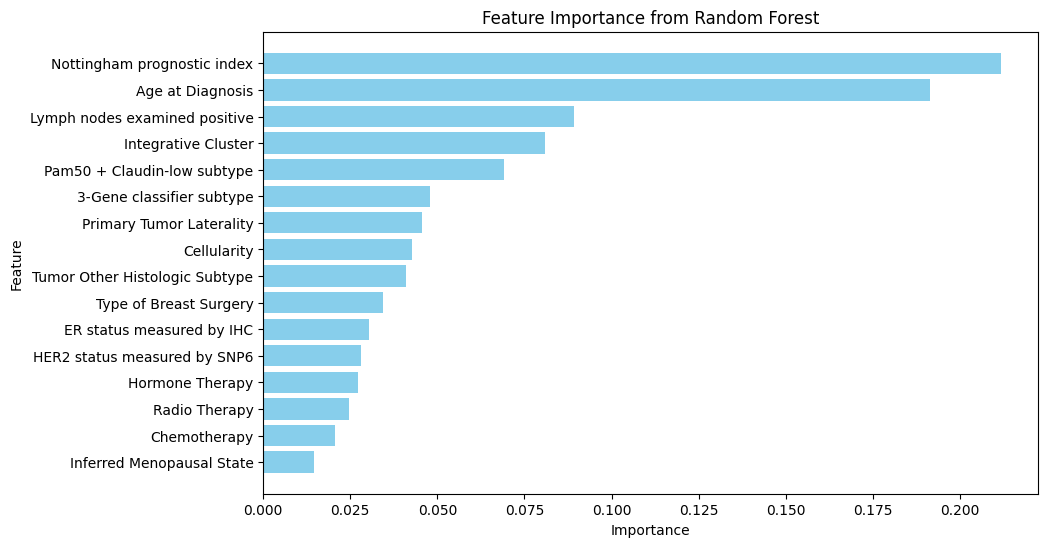

In [86]:
X = clinical_df.drop(columns=['event', 'group']) 
y = clinical_df['event'] 

rf_model = RandomForestClassifier()
rf_model.fit(X, y)

feature_importance = rf_model.feature_importances_

feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance from Random Forest')
plt.gca().invert_yaxis()
plt.savefig(results_dir/'clinical_features_importance.png')
plt.show()

In [87]:
threshold = 0.05
selected_features = X.columns[feature_importance >= threshold]
selected_features

Index(['Lymph nodes examined positive', 'Nottingham prognostic index',
       'Integrative Cluster', 'Age at Diagnosis',
       'Pam50 + Claudin-low subtype'],
      dtype='object')

In [237]:
skip = ['event', 'group']
all_cols = [col for col in clinical_df.columns if col in list(selected_features) + skip]
clinical_df = clinical_df[all_cols]
clinical_df.head()

,Lymph nodes examined positive,Nottingham prognostic index,Integrative Cluster,Age at Diagnosis,Pam50 + Claudin-low subtype,event,group
#Patient Identifier,,,,,,,
MB-5460,1.0,0.561567,10,0.452663,0,0,train
MB-0452,0,0.568284,10,0.437063,3,0,train
MB-0351,1.0,0.0,3,0.640129,3,0,train
MB-0543,1.0,0.756343,0,0.322351,0,0,val
MB-5013,1,0.567164,3,0.627084,2,0,train


In [238]:
clinical_df.to_csv(results_dir/'preprocessed_clinical_data.csv')

### Exploring feature distributions

In [239]:
def plot_histogram(dfs, column_name, file_path, dpi=300, fontsize=8):
    fig, ax = plt.subplots()
    
    for df, label in dfs:
        value_counts = df[column_name].value_counts()
        ax.bar(value_counts.index, value_counts.values, label=label, alpha=0.5)
        
    ax.set_xlabel(column_name)
    ax.set_ylabel('Number of Patients')
    ax.set_title(f'Histogram of {column_name}')
    ax.legend()  
    
    ax.tick_params(axis='x', labelsize=fontsize)  
    
    plt.savefig(file_path, dpi=dpi) 
    plt.show()

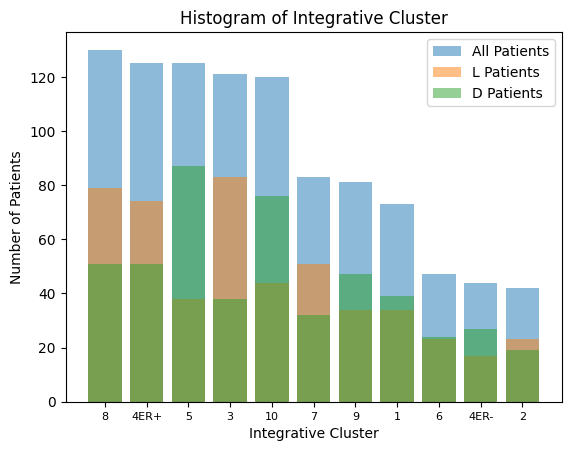

In [240]:
plot_histogram([(clinical_plot, 'All Patients'), (clinical_L_df, 'L Patients'), (clinical_D_df, 'D Patients')],
               'Integrative Cluster', 
               results_dir / 'integrative_cluster_hist_combined.png')

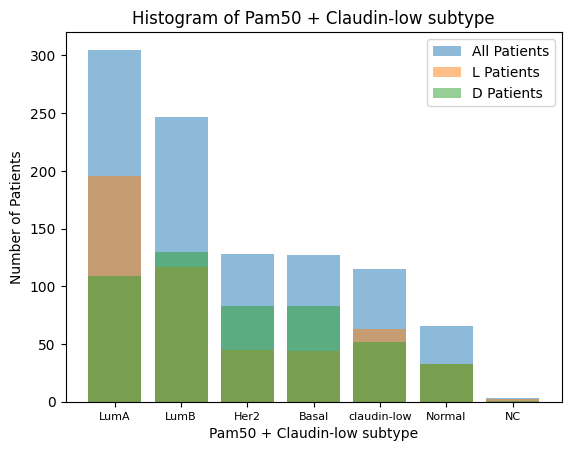

In [241]:
plot_histogram([(clinical_plot, 'All Patients'), (clinical_L_df, 'L Patients'), (clinical_D_df, 'D Patients')],
               'Pam50 + Claudin-low subtype', 
               results_dir / 'Pam50_sybtype_hist_combined.png')

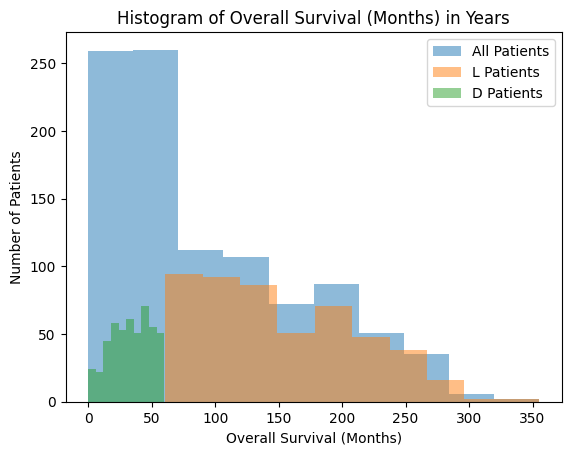

In [244]:
fig, ax = plt.subplots()
column = 'Overall Survival (Months)'

clinical_plot[column].astype(float).plot(kind='hist', ax=ax, alpha=0.5, label='All Patients')
clinical_L_df[column].astype(float).plot(kind='hist', ax=ax, alpha=0.5, label='L Patients')
clinical_D_df[column].astype(float).plot(kind='hist', ax=ax, alpha=0.5, label='D Patients')

ax.set_title(f'Histogram of {column} in Years')
ax.set_xlabel(column)
ax.set_ylabel('Number of Patients')
ax.legend()

plt.savefig(results_dir / 'survival_hist_combined.png', dpi=300)

plt.show()

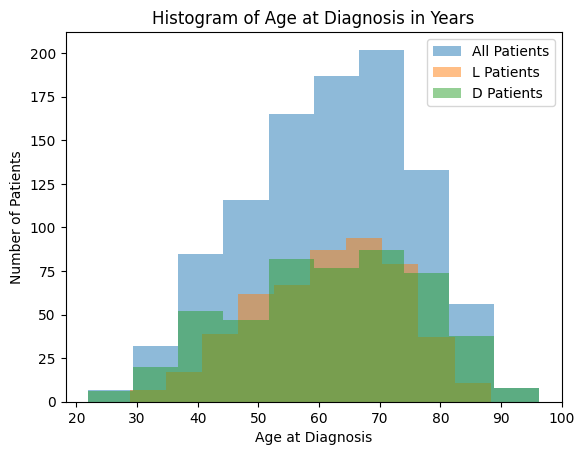

In [245]:
fig, ax = plt.subplots()
column = 'Age at Diagnosis'

clinical_plot[column].astype(float).plot(kind='hist', ax=ax, alpha=0.5, label='All Patients')
clinical_L_df[column].astype(float).plot(kind='hist', ax=ax, alpha=0.5, label='L Patients')
clinical_D_df[column].astype(float).plot(kind='hist', ax=ax, alpha=0.5, label='D Patients')

ax.set_title(f'Histogram of {column} in Years')
ax.set_xlabel(column)
ax.set_ylabel('Number of Patients')
ax.legend()

plt.savefig(results_dir / 'age_hist_combined.png', dpi=300)

plt.show()

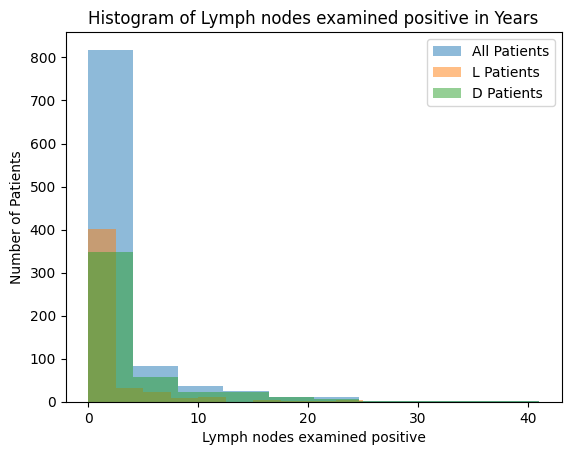

In [88]:
fig, ax = plt.subplots()
column = 'Lymph nodes examined positive'

clinical_plot[column].astype(float).plot(kind='hist', ax=ax, alpha=0.5, label='All Patients')
clinical_L_df[column].astype(float).plot(kind='hist', ax=ax, alpha=0.5, label='L Patients')
clinical_D_df[column].astype(float).plot(kind='hist', ax=ax, alpha=0.5, label='D Patients')

ax.set_title(f'Histogram of {column} in Years')
ax.set_xlabel(column)
ax.set_ylabel('Number of Patients')
ax.legend()

plt.savefig(results_dir / 'lymph_nodes_hist_combined.png', dpi=300)

plt.show()

In [ ]:
fig, ax = plt.subplots()
column = 'Nottingham prognostic index'

clinical_plot[column].astype(float).plot(kind='hist', ax=ax, alpha=0.5, label='All Patients')
clinical_L_df[column].astype(float).plot(kind='hist', ax=ax, alpha=0.5, label='L Patients')
clinical_D_df[column].astype(float).plot(kind='hist', ax=ax, alpha=0.5, label='D Patients')

ax.set_title(f'Histogram of {column} in Years')
ax.set_xlabel(column)
ax.set_ylabel('Number of Patients')
ax.legend()

plt.savefig(results_dir / 'NPI_hist_combined.png', dpi=300)

plt.show()

In [ ]:
#Future work, fixing imbalance with SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)